# Testing Saturation in Flare Models

In [1]:
import pathlib

import astropy.units as u
import astropy.time
import numpy as np
import matplotlib.pyplot as plt
import sunpy.map
import aiapy
from astropy.visualization import quantity_support,ImageNormalize,LogStretch,AsinhStretch,AsymmetricPercentileInterval
from astropy.coordinates import SkyCoord
from astropy.wcs.utils import wcs_to_celestial_frame
import ndcube
from overlappy.util import color_lat_lon_axes

from mocksipipeline.physics.dem.data_prep import DataQuery
from mocksipipeline.physics.spectral import SpectralModel
from mocksipipeline.detector.response import Channel, SpectrogramChannel, ThinFilmFilter
from mocksipipeline.detector.component import DetectorComponent
from mocksipipeline.util import stack_components

In [2]:
flare_time = astropy.time.Time('2022-03-30T17:55')

In [3]:
correction_table = aiapy.calibrate.util.get_correction_table() 
pointing_table = aiapy.calibrate.util.get_pointing_table(flare_time-6*u.h, flare_time+6*u.h)
error_table = aiapy.calibrate.util.get_error_table()

/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 100 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 10 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


In [4]:
temperature_bin_edges = 10**np.arange(5.5, 7.6, 0.1) * u.K

In [5]:
dq = DataQuery('../pipeline-runs/flare-test2',
               flare_time,
               aia_error_table=error_table,
               aia_correction_table=correction_table,
               aia_pointing_table=pointing_table,
               temperature_bin_edges=temperature_bin_edges)

In [8]:
dem_cube = dq.run(max_iterations=50)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2.02k/2.02k [02:09<00:00, 15.6 x10^2 DEM/s]


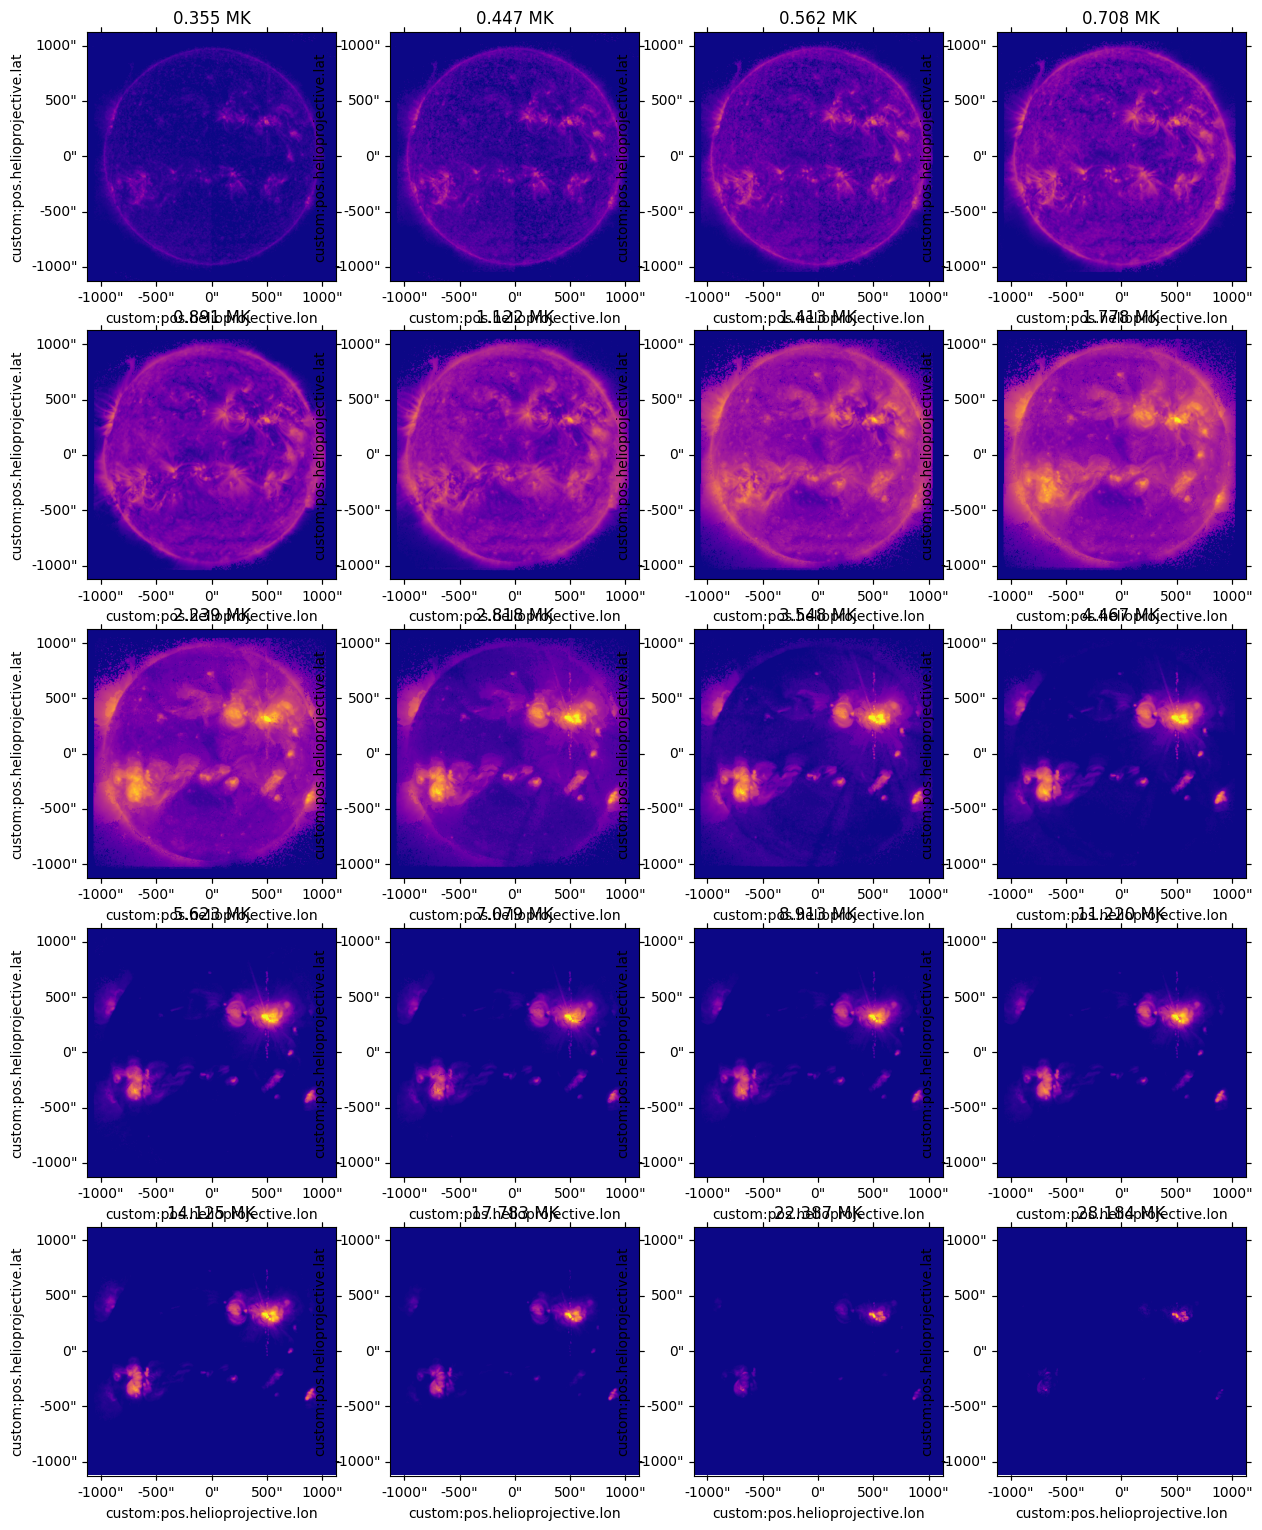

In [9]:
fig = plt.figure(figsize=(15,15*5/4))
for i,cube in enumerate(dem_cube):
    ax = fig.add_subplot(5,4,i+1,projection=cube)
    ax.set_title(f'{dq.temperature_bin_centers[i].to("MK"):.3f}')
    cube.plot(axes=ax,norm=ImageNormalize(vmax=1e28,vmin=1e24,stretch=LogStretch()),cmap='plasma')

In [10]:
spec_model = SpectralModel()

In [11]:
spec_cube = spec_model.run(dem_cube, dq.celestial_wcs)

In [12]:
cube_wave = spec_cube.axis_world_coords(0)[0].to('angstrom')

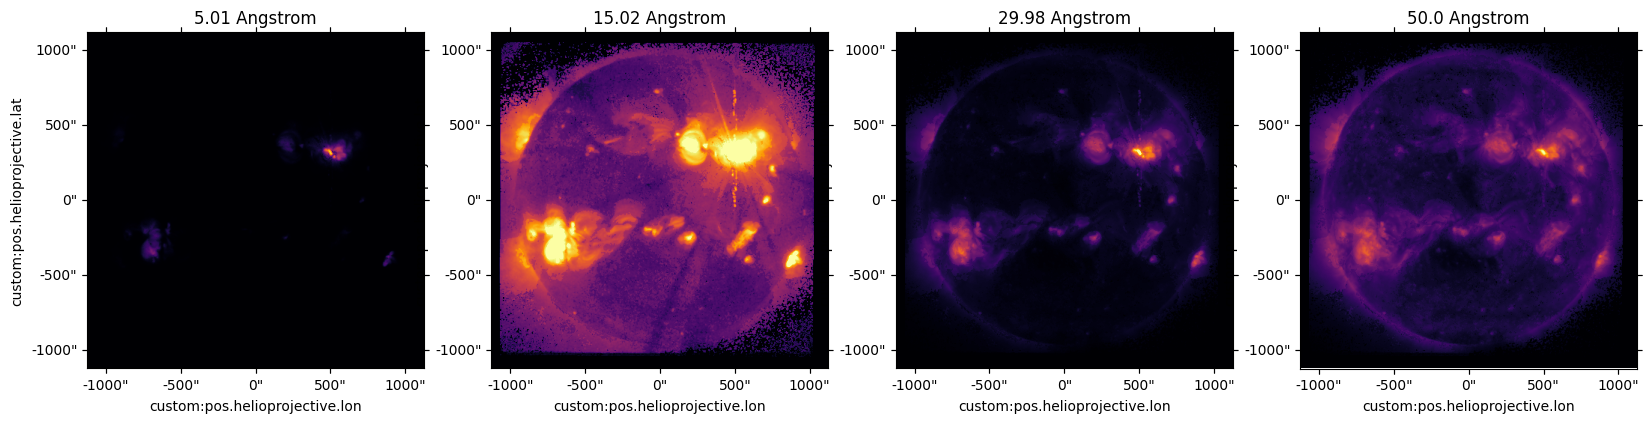

In [15]:
fig = plt.figure(figsize=(20,5))
wave_select = [5.01, 15.02, 29.98, 50] * u.angstrom
norm = ImageNormalize(vmin=0, vmax=1.1e13, stretch=LogStretch())
for i,ws in enumerate(wave_select):
    i_wave = np.argmin(np.fabs(ws - cube_wave))
    cube_slice = spec_cube[i_wave]
    ax = fig.add_subplot(1,4,i+1,projection=cube_slice.wcs)
    cube_slice.plot(axes=ax,norm=norm,cmap="inferno",data_unit='ph /(angstrom cm2 s sr)')
    ax.set_title(ws)

Now, build filter

In [16]:
al_thick_oxide = [
    ThinFilmFilter(elements='Al', thickness=192*u.nm),
    ThinFilmFilter(elements=['Al','O'], quantities=[2,3], thickness=8*u.nm),
]
polymide = ThinFilmFilter(elements=['C','H','N','O'],
                          quantities=[22,10,2,5],
                          density=1.43*u.g/u.cm**3,
                          thickness=100*u.nm)
al_poly_thick_oxide = al_thick_oxide + [polymide]

In [17]:
from dask.distributed import Client

client = Client()
client

2023-01-31 13:34:44,941 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/cr/pj7yk8p976d7ny98bgvlpfyr0000gq/T/dask-worker-space/worker-vie9kcie', purging
2023-01-31 13:34:44,942 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/cr/pj7yk8p976d7ny98bgvlpfyr0000gq/T/dask-worker-space/worker-e1q9pd37', purging
2023-01-31 13:34:44,942 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/cr/pj7yk8p976d7ny98bgvlpfyr0000gq/T/dask-worker-space/worker-o8bm1ag_', purging
2023-01-31 13:34:44,942 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/cr/pj7yk8p976d7ny98bgvlpfyr0000gq/T/dask-worker-space/worker-v8d6n8as', purging
2023-01-31 13:34:44,943 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/cr/pj7yk8p976d7ny98bgvlpfyr0000gq/T/dask-worker-space/worker-zvor_ohu', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 5
Total threads: 10,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:58179,Workers: 5
Dashboard: http://127.0.0.1:8787/status,Total threads: 10
Started: Just now,Total memory: 64.00 GiB
Comm: tcp://127.0.0.1:58209,Total threads: 2
Dashboard: http://127.0.0.1:58211/status,Memory: 12.80 GiB
Nanny: tcp://127.0.0.1:58183,


For this experiment, let's just compute the 0th and 1st orders. We'll do this in photon space, i.e. without including the conversion from photons to electrons.

In [18]:
chan0 = SpectrogramChannel(0, al_poly_thick_oxide)
dc0 = DetectorComponent(chan0)
overlap0 = dc0.compute(spec_cube, electrons=False)

In [38]:
chan1 = SpectrogramChannel(1, al_poly_thick_oxide)
dc1 = DetectorComponent(chan1)
overlap1 = dc1.compute(spec_cube, electrons=False)

In [19]:
overlappogram_total = overlap0
#overlappogram_total = stack_components([overlap0, overlap1], wcs_index=0)

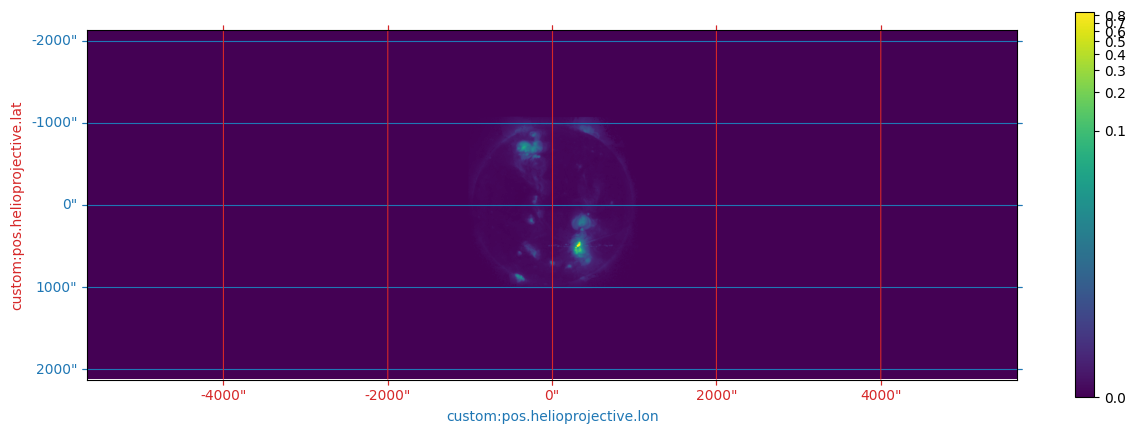

In [23]:
fig = plt.figure(figsize=(15,5))
cropped_cube = overlappogram_total[0,:751,:]
vmin,vmax = AsymmetricPercentileInterval(1,99.999).get_limits(cropped_cube.data)
#vmin,vmax = None, None
norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=LogStretch())
ax = fig.add_subplot(projection=cropped_cube.wcs)
cropped_cube.plot(
    axes=ax,
    norm=norm,
    data_unit='photon / (pix s)',
    cmap='viridis',
)
color_lat_lon_axes(ax)
plt.colorbar()